In [9]:
from google.colab import files
from PIL import Image
from skimage.filters import gaussian
from skimage import exposure,color,filters
import matplotlib.pyplot as plt
import numpy as np
import pywt
import math

ADAPTIVE COLOR CORRECTION


In [10]:
def SSIM(x,y):                                   # Structural Similarity Index Measure
  mu_x             = np.mean(x)                  # mean of x channel
  mu_y             = np.mean(y)                  # mean of y channel
  sig_x            = np.var(x)                   # variance of x channel
  sig_y            = np.var(y)                   # variance of y channel
  sig_xy           = np.cov(x,y)[0,1]            # covariance of x and y channels
  k1               = 0.01
  k2               = 0.03
  n                = 8                           # number of bits per pixel
  L                = 2**n - 1                    # number of levels
  C1               = (k1*L)**2                   # stabilization constant
  C2               = (k2*L)**2                   # stabilization constant
  ssim             = ((2*mu_x*mu_y + C1)*(2*sig_xy + C2))/((mu_x**2 + mu_y**2 + C1)*(sig_x + sig_y + C2))
  return ssim

def PSSIM(red,green,blue):
  g_mean           = np.mean(green)              # mean of green channel
  b_mean           = np.mean(blue)               # mean of blue channel
  g_pssim          = SSIM(green,blue)            # SSIM value of green channel
  b_pssim          = SSIM(green,blue)            # SSIM value of blue channel
  if(g_mean > b_mean):
    r_pssim        = SSIM(red,green)             # SSIM value of red channel for greater green intensity
  else:
    r_pssim        = SSIM(red,blue)              # SSIM value of red channel for greater blue intensity
  return [r_pssim,g_pssim,b_pssim]

def r_compensate(img):
  r_chan           = img[:,:,0]                  # red channel
  g_chan           = img[:,:,1]                  # green channel
  b_chan           = img[:,:,2]                  # blue channel
  T                = 0.7                         # threshold
  alpha            = 0.5                         # compensation factor
  r_chan_comp      = np.zeros_like(r_chan)
  r_mean           = np.mean(r_chan)             # mean of red channel
  g_mean           = np.mean(g_chan)             # mean of green channel
  for i in range(r_chan.shape[0]):
    for j in range(r_chan.shape[1]):
      r_chan_comp[i][j]  = r_chan[i][j] + alpha*(g_mean-r_mean)
  r_pssim          = PSSIM(r_chan,g_chan,b_chan)[0]
  if r_pssim > T:
    r_chan_new     = r_chan
  else:
    r_chan_new     = r_chan_comp
  return r_chan_new

def acc(img):
  r_chan           = img[:,:,0]                                    # red channel
  g_chan           = img[:,:,1]                                    # green channel
  b_chan           = img[:,:,2]                                    # blue channel
  r_chan_new       = r_compensate(img)                             # compensated red channel
  img_comp         = np.stack((r_chan_new,g_chan,b_chan), axis=2)  # red compensated image
  return img_comp

STATIONARY WAVELET TRANSFORM


In [11]:
def wavelet(x):
    coeff          = pywt.swt2(x,'db1',level=1)                    # wavelet transform coeffients of x channel
    return coeff

def gaussian_blur(image, kernel_size=(5, 5), sigma_x=0):
    blurred_image  = gaussian(image,sigma=sigma_x, mode='reflect') # image blurred by a Gaussian filter of size(5,5)
    return blurred_image

def sharpen(x):
    blur           = gaussian_blur(x)                              # blurred channel x
    beta           = 3                                             # sharpening factor
    hp             = np.zeros_like(x)
    res            = np.zeros_like(x)
    for i in range(len(x)):
        hp[i]      = x[i] - blur[i]                                # difference image with edge details
        res[i]     = x[i] + beta*hp[i]                             # sharpened image with highlighted edges
    return res

def swt(x):
  coeff             = wavelet(x)                                   # wavelet transform coefficients
  coeff_new         = [[[],[]]]
  ll                = coeff[0][0]                                  # low frequency components details
  ll_n              = sharpen(ll)                                  # sharpened low frequency details
  coeff_new[0][0]   = ll_n
  coeff_new[0][1]   = coeff[0][1]
  x_n               = pywt.iswt2(coeff_new,'db1')                  # inverse stationary wavelet transform
  x_n_int           = [[int(num) for num in sublist] for sublist in x_n]
  return x_n_int

CONTRAST ENHANCEMENT

In [12]:
# histogram equalization
def histogram_equalization(image):
    hist, bins        = np.histogram(image.flatten(), bins=256, range=(0,255))  # histogram of image
    cdf               = hist.cumsum()                                           # cdf of histogram
    cdf_normalized    = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())       # normalized cdf
    equalized_image   = np.interp(image.flatten(), bins[:-1], cdf_normalized)   # equalized image
    return equalized_image.reshape(image.shape).astype(np.uint8)

In [13]:
# clahe
def clahe(image):
  clahe_channels    = [exposure.equalize_adapthist(channel) for channel in np.rollaxis(image, axis=-1)]      # clahe for each color channel(64 subregions, threshold= 0.01)
  clahe_image       = np.dstack(clahe_channels)                                                              # color channels combined
  return clahe_image

In [14]:
#drshe
def devsum(arr,x,y):
    add                           = 0
    for i in range(-1,1):
        for j in range(-1,1):
            add                   = add + abs(arr[x+i,y+j] - arr[x,y])          # sum of deviations from the centre
    return add

def waad(image):                                                                # weighted average absolute difference
    height,width,depth            = image.shape                                 # dimensions of the image
    zpimg                         = np.zeros((height+2,width+2,3))              # zero padded image creation
    zpimg[1:height+1,1:width+1,:] = image                                       # adding actual image to the zeros
    zpimg[0,:,:],zpimg[-1,:,:]    = zpimg[1,:,:],zpimg[-2,:,:]
    zpimg[:,0,:],zpimg[:,-1,:]    = zpimg[:,1,:],zpimg[:,-2,:]
    imgout                        = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            imgout[i,j,:]         = zpimg[i+1,j+1,:] + devsum(zpimg,i+1,j+1)/8  # waad image
    return imgout

def drange(image):
    hist, bins = np.histogram(image.flatten(), bins=256, range=(0,255))         # histogram of the image
    mx         = max(hist)                                                      # maximum frequency of pixels in the histogram
    k          = 0.2                                                            # threshold factor
    thres      = k*mx/100                                                       # minimum threshold
    for i in range(len(hist)):
      if(hist[i]<thres):
        hist[i] = 0
    start       = 0
    end         = len(hist)-1
    for i in range(len(hist)):
      if(hist[i]==0):
        start   = start + 1                                                     # dynamic start point
      else:
        break
    for i in range(len(hist)):
      if(hist[-i-1]==0):
        end     = end - 1                                                       # dynamic end point
      else:
        break
    return [start,end]

def subhist(image, start, end, k=4):
    step       = np.linspace(start,end,k+1)                                     # dividing dynamic range in k subparts
    for i in range(len(step)):
      step[i]  = math.floor(step[i])                                            # retaining only integer part
    subrange   = []
    for i in range(k):
      subrange.append(np.arange(step[i],step[i+1]))
    return subrange

def arsh(hist,subhist,n):
    s          = 0
    for i in subhist:
      s        = s + hist[int(i)]                                               # sum of histogram frequency pixel values
    return s/n,round(s*255/n)

def scale_factor(newimage ,s, e, alpha = 0.5, k = 4):
    r              = 255/k                                                      # subrange length
    hist, bins     = np.histogram(newimage.flatten(), bins=256, range=(0,255))  # histogram of the image
    n              = sum(hist[s:e+1])                                           # number of pixels in the the dynamic range of the histogram
    subrange       = subhist(newimage,s,e,k)
    artio          = []
    rgr            = []
    argr           = []
    for i in range(len(subrange)):
      temp1, temp2 = arsh(hist,subrange[i],n)
      artio.append(temp1)                                                       # area ratio of the different subhistograms
      rgr.append(temp2)                                                         # resized graysclae range
      temp3        = temp2 + alpha*(r - temp2)
      argr.append(temp3)                                                        # adjusted resized grayscale range
    return argr

def power_law(image , gamma , max_pixel_value = 256):
  c                     = 255/math.log10(1+max_pixel_value)                     # gamma correction constant
  imout                 = np.zeros_like(image)
  h,w,d                 = np.shape(image)                                       # dimensions of the image
  for i in range(h):
    for k in range(w):
      for m in range(d):
        imout[i][k][m]  =  c*math.pow(image[i][k][m]/255,gamma)                 # gamma corrected image
  return imout

def drshe(image,k=4):
  imgwaad               = waad(image)                                           # waad image
  imgout                = np.zeros_like(imgwaad)
  start, end            = drange(imgwaad)                                       # dynamic range of histogram
  argr                  = scale_factor(imgwaad,start,end,0.1,k)                 # adjusted resized grayscale range
  sdr                   = (end-start)/k                                         # subhistogram length
  l                     = 255-end                                               # pixels outside dynamic range
  h,w,d                 = np.shape(imgwaad)                                     # dimensions of the image
  gamma                 = 2                                                     # gamma factor
  for i in range(h):
    for k in range(w):
      for m in range(d):
        imgout[i][k][m] = (imgwaad[i][k][m] - start - sdr) * argr[0]/sdr  + sum(argr)
  imgamma               = power_law(imgout,gamma)
  return imgamma

IMAGE UPLOAD


In [15]:
uploaded = files.upload()

Saving f_r_1340_.jpg to f_r_1340_ (1).jpg


MAIN PROGRAM


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 226 fits in uint16
  return _convert(image, np.uint16, force_copy)
/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 255 fits in uint16
  return _convert(image, np.uint16, force_copy)


(-0.5, 639.5, 479.5, -0.5)

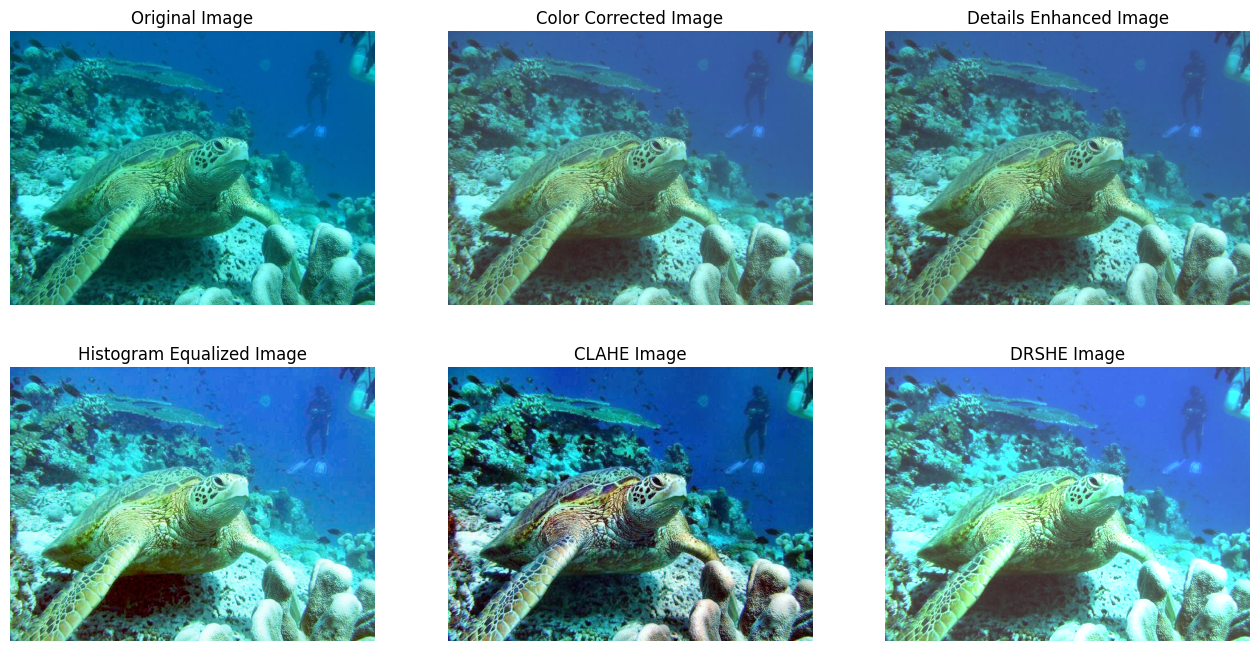

In [16]:
image         = Image.open(list(uploaded.keys())[0])                            # original image
img           = np.array(image)
red           = img[:,:,0]                                                      # original red channel
green         = img[:,:,1]                                                      # original green channel
blue          = img[:,:,2]                                                      # original blue channel

corrected_img = acc(img)                                                        # color corrected image
red_c         = corrected_img[:,:,0]                                            # color corrected red channel
green_c       = corrected_img[:,:,1]                                            # color corrected green channel
blue_c        = corrected_img[:,:,2]                                            # color corrected blue channel

red_cn        = swt(red_c)                                                      # sharpened red channel
green_cn      = swt(green_c)                                                    # sharpened green channel
blue_cn       = swt(blue_c)                                                     # sharpened blue channel
img_cn        = np.stack((red_cn,green_cn,blue_cn), axis=2)                     # sharpened image

img_equi_1    = histogram_equalization(img_cn)                                  # histogram equalized image
clahe_image   = clahe(img_cn)                                                   # clahe image
drshe_image   = drshe(img_cn)                                                   # drshe image

plt.figure(figsize=(16,8))
plt.subplot(231)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.subplot(232)
plt.imshow(corrected_img)
plt.title("Color Corrected Image")
plt.axis("off")
plt.subplot(233)
plt.imshow(img_cn)
plt.title("Details Enhanced Image")
plt.axis("off")
plt.subplot(234)
plt.imshow(img_equi_1)
plt.title("Histogram Equalized Image")
plt.axis("off")
plt.subplot(235)
plt.imshow(clahe_image)
plt.title("CLAHE Image")
plt.axis("off")
plt.subplot(236)
plt.imshow(drshe_image)
plt.title("DRSHE Image")
plt.axis("off")